# Populations and Catalogs

We will be working toward a full analysis of the mass function from {cite}`Schneider2018`.  The data can be downloaded [here](https://www.science.org/doi/10.1126/science.aan0106) and consist of estimates of the stellar properties of massive stars observed in the 30 Doradus star forming region with the VLT-FLAMES survey.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [61]:
import astropy.io.ascii as aia
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')
sns.set_style('ticks')

In [50]:
data_30dor = aia.read('data/aan0106_data_s1.txt', delimiter='\t', 
                      names=['VFTS Identifier', 'Spectral type', 
                             'logL', 'd+logL', 'd-logL', 'logLCI', 
                             'Teff', 'd+Teff', 'd-Teff', 'TeffCI', 
                             'logg', 'd+logg', 'd-logg', 'loggCI',
                             'vsini', 'd+vsini', 'd-vsini', 'vsiniCI',
                             'Y', 'd+Y', 'd-Y', 'YCI',
                             'Reference', 
                             'Mini', 'd+Mini', 'd-Mini', 'MiniCI',
                             'vini', 'd+vini', 'd-vini', 'viniCI',
                             'Age', 'd+Age', 'd-Age', 'AgeCI',
                             'Mpresent', 'd+Mpresent', 'd-Mpresent', 'MpresentCI',
                             'R', 'd+R', 'd-R', 'RCI'],
                      fill_values=[('-', 'NaN'), ('25.0-30.0', 'NaN'), ('30.0-60.0', 'NaN'), ('>25.0', 'NaN'), ('>27.0', 'NaN')]).to_pandas()
data_30dor

,VFTS Identifier,Spectral type,logL,d+logL,d-logL,logLCI,Teff,d+Teff,d-Teff,TeffCI,...,d-Age,AgeCI,Mpresent,d+Mpresent,d-Mpresent,MpresentCI,R,d+R,d-R,RCI
0,3,B1 Ia+,6.03,0.10,0.10,68.3,21000.0,1000.0,1000.0,68.3,...,0.3,68.3,56.4,10.3,7.8,69.2,74.2,16.1,9.2,68.3
1,4,B2 V,3.85,0.10,0.10,68.3,20000.0,1020.0,1020.0,68.3,...,3.3,68.3,8.0,0.5,0.4,68.3,5.7,0.8,0.6,68.3
2,5,B2 V(n),3.82,0.10,0.10,68.3,19000.0,1000.0,1000.0,68.3,...,3.0,68.3,8.0,0.4,0.6,68.3,7.7,0.9,0.7,68.3
3,6,Mid-late K,3.46,0.20,0.20,68.3,4100.0,150.0,150.0,68.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,B1-2 V,3.64,0.11,0.11,68.3,20000.0,1210.0,1210.0,68.3,...,4.2,68.3,7.4,0.4,0.6,68.3,5.7,0.8,0.6,68.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,1001,WN6(h),6.20,0.10,0.10,68.3,42170.0,1520.0,1520.0,68.3,...,0.3,68.3,57.6,11.6,6.5,68.3,27.7,2.8,4.5,68.3
567,1017,O2 If*/WN5,6.21,0.10,0.10,68.3,50120.0,1800.0,1800.0,68.3,...,0.4,68.3,79.0,17.8,15.9,69.9,16.9,2.7,2.7,68.3
568,1021,O4 If+,6.10,0.10,0.10,68.3,35500.0,1500.0,1500.0,68.3,...,0.2,68.3,71.4,12.7,9.2,68.5,30.1,4.2,3.3,68.3
569,1022,O3.5 If*/WN7,6.48,0.10,0.10,68.3,42170.0,1520.0,1520.0,68.3,...,0.1,68.3,142.8,25.6,25.2,68.3,32.5,4.7,4.4,68.3


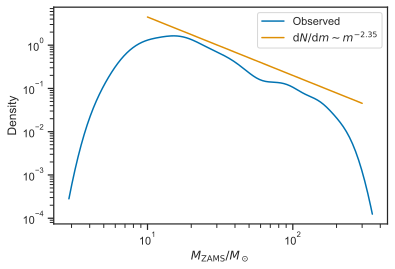

In [58]:
sns.kdeplot(data_30dor['Mini'], log_scale=True, label='Observed')
ms = exp(linspace(log(10), log(300), 100))
plot(ms, 100*ms*ms**-2.35, label=r'$\mathrm{d}N/\mathrm{d}m \sim m^{-2.35}$')
yscale('log')
xlabel(r'$M_\mathrm{ZAMS} / M_\odot$')
legend(loc='best')

In [66]:
MMin = 20
masses = data_30dor['Mini']
masses = masses[(~isnan(masses)) & (masses > MMin)]
with pm.Model() as salp_model:
    # dN/dm = (A/20)*(m/20)^-alpha
    alpha = pm.Bound(pm.Normal, lower=1)('alpha', mu=2.5, sigma=1)
    A = pm.Lognormal('A', mu=log(500), sigma=1)

    def log_dNdm(m):
        return tt.log(A) - tt.log(MMin) - alpha*(tt.log(m) - tt.log(MMin))
    
    Lambda = pm.Deterministic('Lambda', A/(alpha-1))
    
    # sum(log(dN/dm_i)) - Lambda
    pm.Potential('likelihood', tt.sum(log_dNdm(masses)))
    pm.Potential('normalization', -Lambda)

In [67]:
with salp_model:
    salp_trace = pmx.sample()

/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


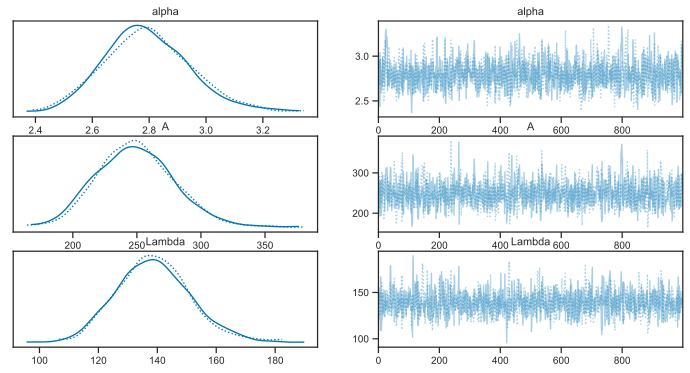

In [68]:
with salp_model:
    pm.plot_trace(salp_trace)